In [1]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


2025-01-02 23:04:24.750985: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-02 23:04:24.773198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735830264.788099  125949 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735830264.793184  125949 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 23:04:24.811919: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
df_train.columns = ['label', 'title', 'text']
df_train.head()

,label,title,text
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [3]:
df_test.columns = ['label', 'title', 'text']
df_test.head()

,label,title,text
0,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
1,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
2,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
3,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
4,1,DVD Player crapped out after one year,I also began having the incorrect disc problem...


In [4]:
df_train = df_train.head(500000)
df_test = df_test.head(50000)

In [5]:
def concat_columns(df, col1, col2, new_col):
    df[new_col] = df[col1].apply(str) + ' ' + df[col2].apply(str)
    df.drop(col2, axis = 1, inplace = True)
    return df

df_train = concat_columns(df_train, 'text', 'title', 'text')
df_test = concat_columns(df_test, 'text', 'title', 'text')

# Map labels for binary classification
df_train['label'] = df_train['label'].map({1: 0, 2: 1})
df_test['label'] = df_test['label'].map({1: 0, 2: 1})



In [6]:
df_train.head()

,label,text
0,1,I'm reading a lot of reviews saying that this ...
1,1,This soundtrack is my favorite music of all ti...
2,1,I truly like this soundtrack and I enjoy video...
3,1,"If you've played the game, you know how divine..."
4,1,I am quite sure any of you actually taking the...


data clean

In [7]:
def clean_text(text):
    text = re.sub(r'[^A-Za-zÀ-ú ]+', '', text)  # Keep only letters
    #text = re.sub('book|one', '', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)


In [8]:
df_train.head()

,label,text
0,1,im reading a lot of reviews saying that this i...
1,1,this soundtrack is my favorite music of all ti...
2,1,i truly like this soundtrack and i enjoy video...
3,1,if youve played the game you know how divine t...
4,1,i am quite sure any of you actually taking the...


In [9]:
max_words = 10000
max_len = 530

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['text'])

train_sequences = tokenizer.texts_to_sequences(df_train['text'])
test_sequences = tokenizer.texts_to_sequences(df_test['text'])

word_index = tokenizer.word_index 

train_pad = pad_sequences(train_sequences, maxlen=max_len)
test_pad = pad_sequences(test_sequences, maxlen=max_len)


In [10]:
df_train.head()

,label,text
0,1,im reading a lot of reviews saying that this i...
1,1,this soundtrack is my favorite music of all ti...
2,1,i truly like this soundtrack and i enjoy video...
3,1,if youve played the game you know how divine t...
4,1,i am quite sure any of you actually taking the...


In [8]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, max_len))
model.summary()


I0000 00:00:1735828320.831574  119800 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13689 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 530, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 530, 32)        │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 530, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,785 (839.00 KB)

 Trainable params: 214,721 (838.75 KB)

 Non-trainable params: 64 (256.00 B)

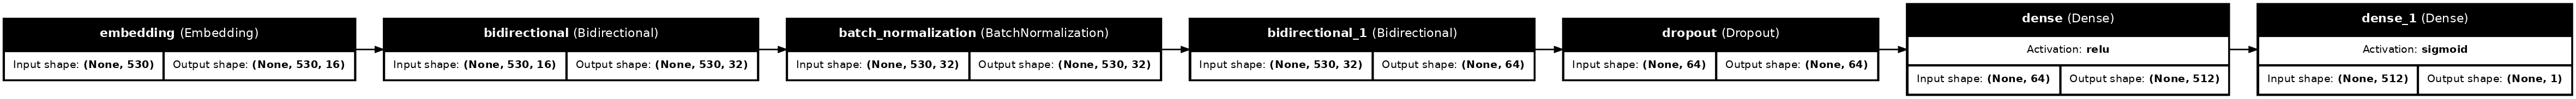

In [20]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True, dpi=100, show_layer_activations=True, expand_nested=True, rankdir='LR')

In [9]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history = model.fit(
    train_pad,
    df_train['label'],
    validation_split=0.1,
    epochs=10,
    batch_size=64
)

Epoch 1/10


I0000 00:00:1735817678.558611   85832 cuda_dnn.cc:529] Loaded cuDNN version 90300


7032/7032 ━━━━━━━━━━━━━━━━━━━━ 966s 137ms/step - accuracy: 0.8744 - loss: 0.2873 - val_accuracy: 0.9260 - val_loss: 0.1905
Epoch 2/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 972s 138ms/step - accuracy: 0.9354 - loss: 0.1701 - val_accuracy: 0.9337 - val_loss: 0.1720
Epoch 3/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 925s 132ms/step - accuracy: 0.9458 - loss: 0.1452 - val_accuracy: 0.9346 - val_loss: 0.1700
Epoch 4/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 965s 137ms/step - accuracy: 0.9536 - loss: 0.1272 - val_accuracy: 0.9324 - val_loss: 0.1746
Epoch 5/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 942s 134ms/step - accuracy: 0.9604 - loss: 0.1111 - val_accuracy: 0.9331 - val_loss: 0.1857
Epoch 6/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 980s 139ms/step - accuracy: 0.9653 - loss: 0.0984 - val_accuracy: 0.9303 - val_loss: 0.1893
Epoch 7/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 971s 138ms/step - accuracy: 0.9700 - loss: 0.0865 - val_accuracy: 0.9275 - val_loss: 0.2035
Epoch 8/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 965s 137ms/step - accuracy: 0.9

In [10]:
model.evaluate(test_pad, df_test['label'])

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 97s 62ms/step - accuracy: 0.9221 - loss: 0.2484


[0.24734820425510406, 0.9226400256156921]

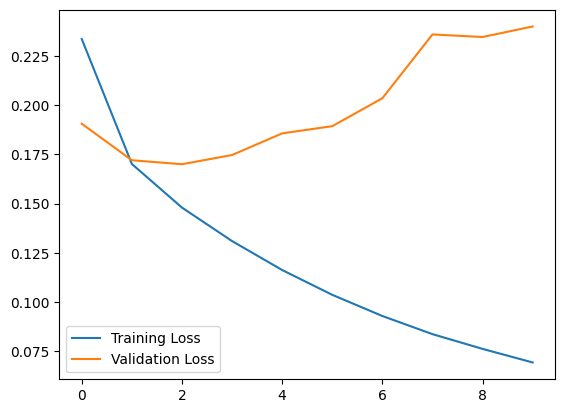

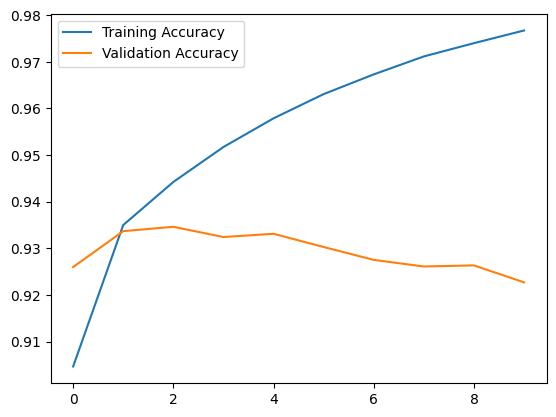

In [11]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [12]:
model.save('lstm_model.h5')

In [15]:
model = load_model('lstm_model.h5')

# Function to preprocess new text 
def preprocess_text(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    return padded_sequence

# Function to predict sentiment
def predict_sentiment(text):
    processed_text = preprocess_text(text)
    prediction = model.predict(processed_text)
    return prediction[0][0]

new_review = "I don’t usually like products like this, but this one exceeded my expectations."
sentiment_score = predict_sentiment(new_review)
print(f"Sentiment Score: {sentiment_score}")

if sentiment_score > 0.5:
    print("Recommend this product.")
else:
    print("Do not recommend this product.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Sentiment Score: 0.9950483441352844
Recommend this product.
